In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import gradio as gr

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage", #folder name
     shuffle = True,
     image_size= (IMAGE_SIZE,IMAGE_SIZE),
     batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)

(32, 256, 256, 3)


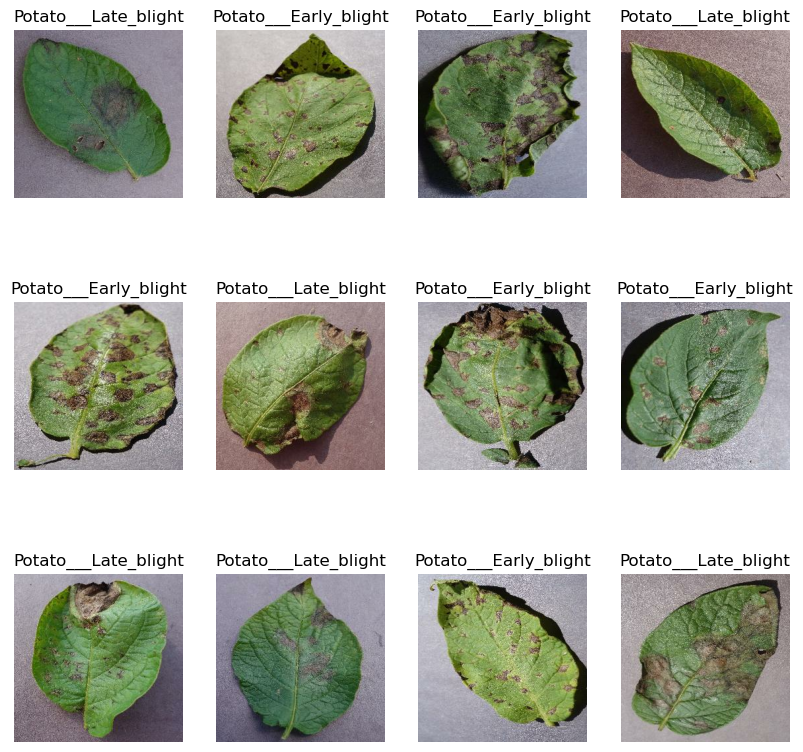

In [104]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
   for i in range(12): 
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")
   

In [105]:
# 80% ==> training
# 20% ==> 10% validation (used to compare with training ds), 10% test

In [106]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [107]:
train_ds = dataset.take(54)
len(train_ds)

54

In [108]:
test_ds = dataset.skip(54) 
len(test_ds)

14

In [109]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [110]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [111]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [112]:
#TRAIN TEST SPLIT

def get_data_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [113]:
train_ds, val_ds, test_ds = get_data_partitions_tf(dataset)

In [114]:
len(train_ds)

54

In [115]:
len(val_ds)

6

In [116]:
len(test_ds)

8

In [117]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [118]:
#supply an image that is not (256,256) and this layer will resize it

resize_and_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [119]:
#Data Augmentation

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [120]:
#Model Architecture

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape), 
    layers.AveragePooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation = "relu"),
    layers.Dense(n_classes, activation = 'softmax'),
])

model.build(input_shape=input_shape)

In [121]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_14 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 sequential_15 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 conv2d_5 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 average_pooling2d_1 (Avera  (32, 127, 127, 32)        0         
 gePooling2D)                                                    
                                                                 
 flatten_5 (Flatten)         (32, 516128)              0         
                                                                 
 dense_10 (Dense)            (32, 64)                  33032256  
                                                     

In [124]:
model.compile(
    optimizer='SGD',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [125]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/30
54/54 [==============================] - 25s 442ms/step - loss: 3.4512 - accuracy: 0.4873 - val_loss: 3.5645 - val_accuracy: 0.4427
Epoch 2/30
54/54 [==============================] - 23s 436ms/step - loss: 1.0400 - accuracy: 0.4722 - val_loss: 1.0205 - val_accuracy: 0.4427
Epoch 3/30
54/54 [==============================] - 27s 511ms/step - loss: 0.9780 - accuracy: 0.4722 - val_loss: 1.0067 - val_accuracy: 0.4427
Epoch 4/30
54/54 [==============================] - 24s 446ms/step - loss: 0.9557 - accuracy: 0.4722 - val_loss: 0.9897 - val_accuracy: 0.4427
Epoch 5/30
54/54 [==============================] - 24s 437ms/step - loss: 0.9393 - accuracy: 0.4722 - val_loss: 0.9836 - val_accuracy: 0.4427
Epoch 6/30
54/54 [==============================] - 22s 410ms/step - loss: 0.9267 - accuracy: 0.4722 - val_loss: 0.9692 - val_accuracy: 0.4427
Epoch 7/30
54/54 [==============================] - 24s 447ms/step - loss: 0.9172 - accuracy: 0.4722 - val_loss: 0.9743 - val_accuracy: 0.4427

In [127]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 1s 119ms/step - loss: 0.9398 - accuracy: 0.4961


In [128]:
scores

[0.9397621154785156, 0.49609375]

In [129]:
history

In [130]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [131]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [132]:
history.history['accuracy']

[0.48726850748062134,
 0.4722222089767456,
 0.4722222089767456,
 0.4722222089767456,
 0.4722222089767456,
 0.4722222089767456,
 0.4722222089767456,
 0.4722222089767456,
 0.4722222089767456,
 0.4739583432674408,
 0.48726850748062134,
 0.49247685074806213,
 0.5115740895271301,
 0.5133101940155029,
 0.5219907164573669,
 0.5347222089767456,
 0.5839120149612427,
 0.5462962985038757,
 0.6672453880310059,
 0.6626157164573669,
 0.6307870149612427,
 0.7054398059844971,
 0.6203703880310059,
 0.6990740895271301,
 0.6944444179534912,
 0.7262731194496155,
 0.6811342835426331,
 0.7152777910232544,
 0.6996527910232544,
 0.7320601940155029]

In [133]:
history.history['val_accuracy']

[0.4427083432674408,
 0.4427083432674408,
 0.4427083432674408,
 0.4427083432674408,
 0.4427083432674408,
 0.4427083432674408,
 0.4427083432674408,
 0.4427083432674408,
 0.4427083432674408,
 0.4427083432674408,
 0.46875,
 0.4479166567325592,
 0.4583333432674408,
 0.5520833134651184,
 0.5260416865348816,
 0.5052083134651184,
 0.5104166865348816,
 0.5208333134651184,
 0.6354166865348816,
 0.6822916865348816,
 0.53125,
 0.59375,
 0.65625,
 0.5364583134651184,
 0.6614583134651184,
 0.515625,
 0.6979166865348816,
 0.71875,
 0.703125,
 0.53125]

In [134]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

<function matplotlib.pyplot.show(close=None, block=None)>

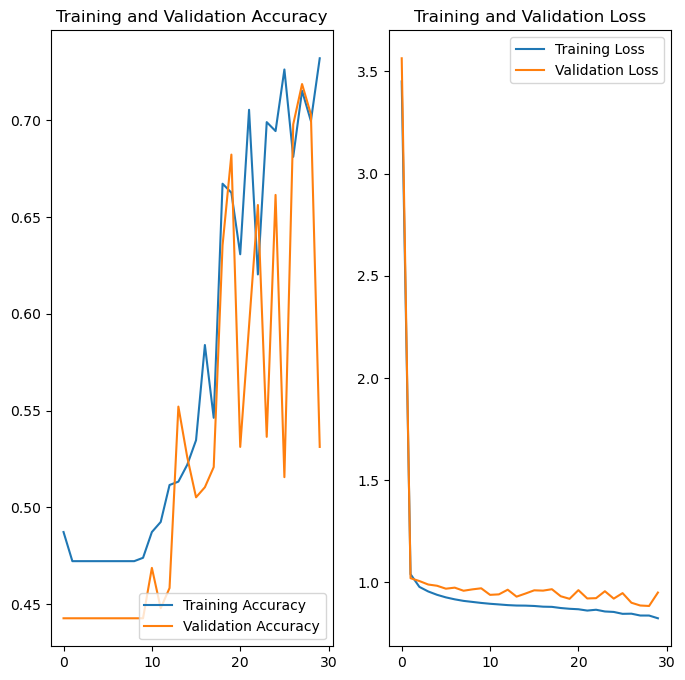

In [135]:
plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 215ms/step
predicted label: Potato___Late_blight


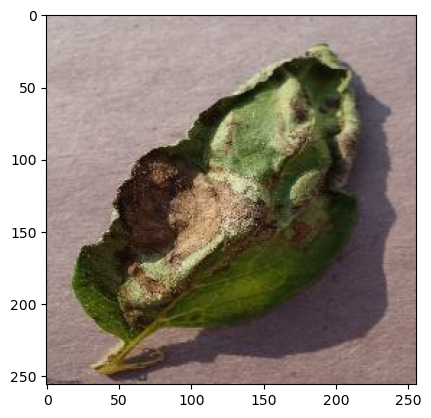

In [136]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [137]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 28ms/step


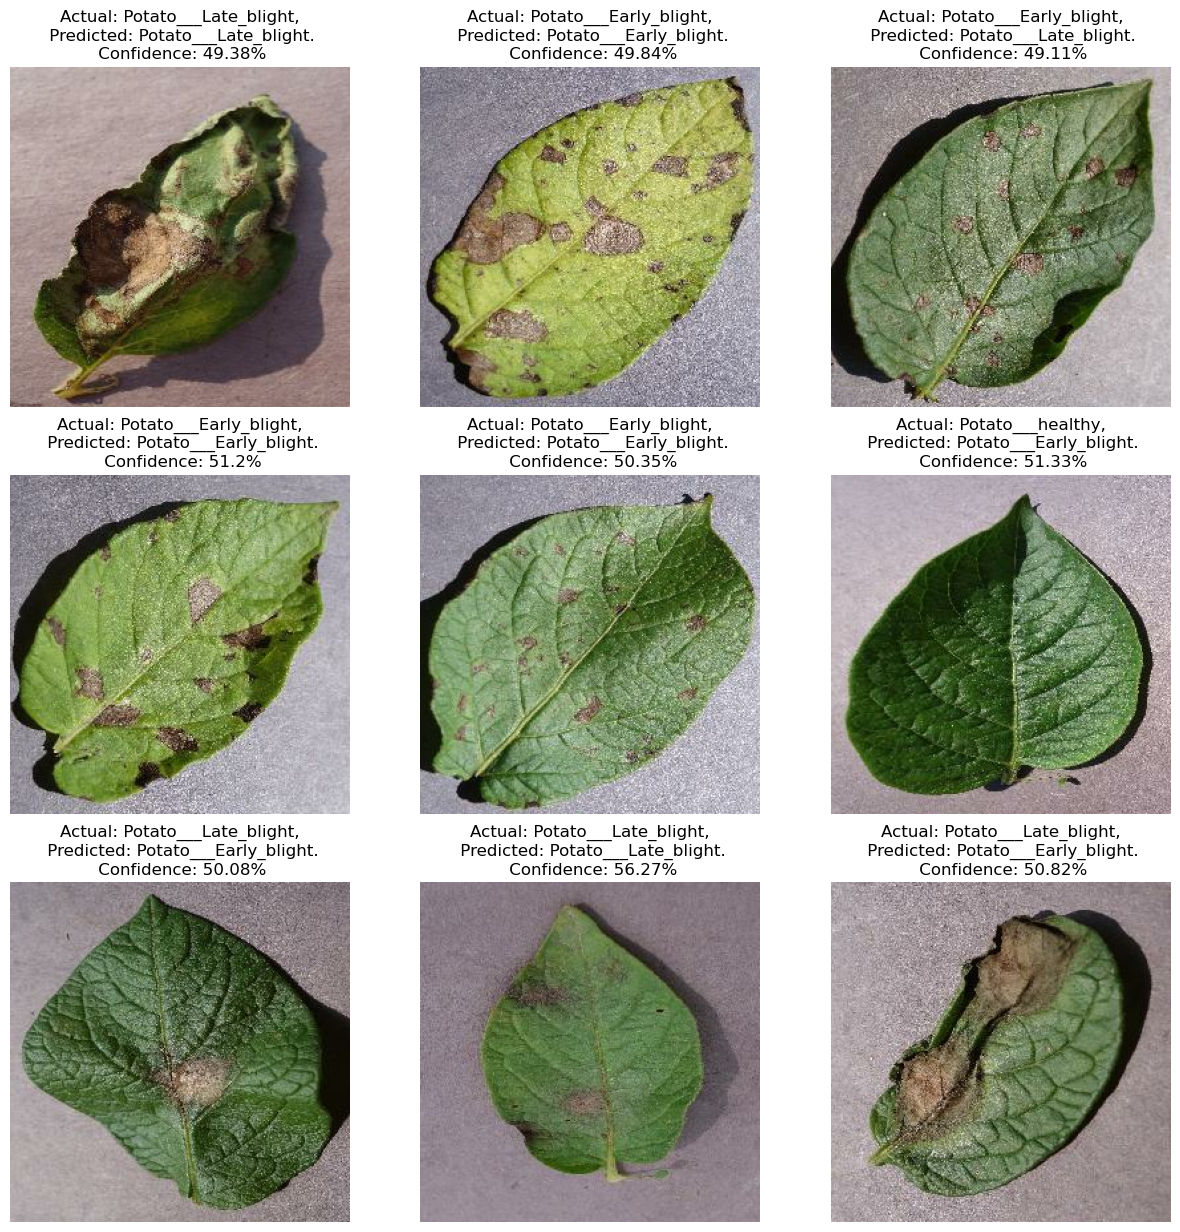

In [138]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [139]:
model_version = 2
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets


In [149]:
def classify_image(inp):
  inp = inp.reshape((-1, 224, 224, 3))
  prediction = model.predict(inp).flatten()
  confidences = {class_names[i]: float(prediction[i]) for i in range(3)}
  return confidences

In [150]:
gr.Interface(fn=classify_image,
             inputs=gr.Image(shape=(224, 224)),
             outputs=gr.Label(num_top_classes=3)).launch()

Running on local URL:  http://127.0.0.1:7880

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 118ms/step
